In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import wandb
import pandas as pd

In [2]:
from sine_data_generator import SineDataGenerator
from models.decoder import Decoder
from models.utils import ReluNet, make_leave_one_out
from models.encoder import DeterministicIOPairSetEncoder
from models.lpn import DeterministicLPN


In [3]:
np.random.seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

d_latent = 2

In [4]:

# Create encoder
encoder = DeterministicIOPairSetEncoder(
    phi=ReluNet(2, 32, 32),
    rho_0=ReluNet(32, 32, 16),
    rho_1=ReluNet(16, 8, d_latent)
)

# Create decoder
decoder = Decoder(
    d_input=1, 
    d_latent=d_latent, 
    ds_hidden=[32, 32], 
    d_output=1
)

# Create the model
lpn = DeterministicLPN(
    d_input=1,
    d_output=1,
    d_latent=d_latent,
    encoder=encoder,
    decoder=decoder
).to(device)

# Create data generator for training
n_samples_per_task = 20
batch_size = 25
data_gen = SineDataGenerator(n_samples_per_task, batch_size)
print(type(data_gen))
print(data_gen.generate()[0].shape)

<class 'sine_data_generator.SineDataGenerator'>
torch.Size([25, 20, 1])


In [5]:
# Training function
def train_deterministic_lpn(lpn, data_gen, device):
    wandb.init(project="deterministic_lpn4sine_cf_maml")
        
    n_metaiter = 30_001 
    n_samples_per_task = 20
    batch_size = 25
    numstep = 2 # changed this from 1
    d_latent = lpn.d_latent
    
    print("Total parameters:", sum(p.numel() for p in lpn.parameters()))
    
    optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)
    
    losses = []
    
    for i in range(n_metaiter):
        lpn.train()
        optimizer.zero_grad()
        
        xs, ys, amp, phase = data_gen.generate()
        io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)
        
        _, loss = lpn(io_pairs, K=numstep, debug=(i==0))
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            wandb.log({"loss": loss.item()})
            losses.append(loss.item())
        if i % 1000 == 0:
            print(f"Step {i}, Loss: {loss.item():.4f}")
    
    # Save the model
    torch.save(lpn.state_dict(), f'deterministic_lpn_H{d_latent}_GA{numstep}.pth')
    wandb.finish()
    
    return losses

# Evaluation function
def evaluate_deterministic_lpn(lpn, device):
    n_test_points = 2000
    test_batch_size = 1
    n_test_samples_per_task = 20
    n_support_samples_per_task = 10
    n_query_samples_per_task = n_test_samples_per_task - n_support_samples_per_task
    
    test_numstep = 10 #100
    data_gen = SineDataGenerator(n_test_samples_per_task, test_batch_size)
    
    
    metaeval_losses = np.full((n_test_points, test_numstep + 1), np.nan)
    
    for i_test_task in range(n_test_points):
        test_xs, test_ys, amp, phase = data_gen.generate()
        support_xs = test_xs[:, :n_support_samples_per_task, :]
        support_ys = test_ys[:, :n_support_samples_per_task, :]
        query_xs = test_xs[:, n_support_samples_per_task:, :]
        query_ys = test_ys[:, n_support_samples_per_task:, :]
        
        support_pairs = torch.cat([support_xs, support_ys], dim=-1).to(device)
        aux_t, loss_t = lpn(support_pairs, K=test_numstep, debug=True)
        
        # Note: Different key names from the probabilistic version
        z_traj = aux_t["z_traj"]
        print(len(z_traj))
        print(test_numstep + 1)
        assert len(z_traj) == test_numstep + 1
        for i_step, z in enumerate(z_traj):
            z = z.mean(dim=1).squeeze(0)  # (d_latent,)
            
            # Evaluate MSE loss of z on the query set
            query_ys_pred = lpn.decode(z, query_xs.squeeze(0).to(device))
            mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')
            metaeval_losses[i_test_task, i_step] = mse.item()
    
    # Calculate confidence intervals correctly
    n_samples = metaeval_losses.shape[0]
    metaeval_mu = metaeval_losses.mean(axis=0)
    metaeval_ci = 1.96 * metaeval_losses.std(axis=0) / np.sqrt(n_samples)
    
    lower_err = np.minimum(metaeval_ci, metaeval_mu)  # ensures lower bound ≥ 0
    upper_err = metaeval_ci
    yerr = np.vstack([lower_err, upper_err])
    
    x = np.arange(test_numstep + 1)
    plt.errorbar(x, metaeval_mu, yerr=yerr, fmt='-o')
    plt.fill_between(x, np.maximum(0, metaeval_mu - metaeval_ci), metaeval_mu + metaeval_ci, alpha=0.2)
    
    plt.xlabel('Gradient Steps')
    plt.ylabel('Loss')
    plt.title('Meta-evaluation Loss vs Gradient Steps (Deterministic LPN)')
    plt.show()
    
    return metaeval_losses, metaeval_mu, metaeval_ci

# Visualization function
def visualize_deterministic_lpn(lpn, device):
    # Generate test data
    test_xs, test_ys, amp, phase = SineDataGenerator(10, 1).generate()
    
    amp = amp.item()
    phase = phase.item()
    
    io_pairs_t = torch.cat([test_xs, test_ys], dim=-1).to(device)
    aux_t, loss_t = lpn(io_pairs_t, K=200, debug=True)
    
    y_pred = aux_t["ys_pred"].detach().cpu().numpy()
    
    # Note: Different key names compared to the probabilistic version
    z = aux_t["z"].detach() if "z" in aux_t else None
    z_prime = aux_t["z_prime"].detach()
    
    # Plot visualization
    x = np.linspace(-5, 5, 200)
    
    for i in range(10):
        # Plot ground-truth
        y = amp * np.sin(x - phase)
        plt.plot(x, y, label=f"ground-truth", color='blue', alpha=.5, zorder=20)
        
        # Plot samples
        plt.scatter(test_xs, test_ys, label=f"samples", color='blue', marker='s', zorder=30)
        
        # Plot target x,y (sample i of batch 0), and its prediction
        x_i = test_xs[0, i].item()
        y_i = test_ys[0, i].item()
        yhat_i = y_pred[0, i].item()
        plt.scatter(x_i, y_i, marker='s', color='green', label=f"target ground-truth", zorder=60)
        plt.scatter(x_i, yhat_i, marker='o', color='k', label=f"target prediction", zorder=70)
        
        # Plot the predicted latent program
        x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (200, 1)
        
        # Plot using initial z if available
        if z is not None:
            z_i = z[0, i]
            y_pred_z_i = lpn.decode(z_i, x_prep).detach().cpu().numpy()
            plt.plot(x, y_pred_z_i, label="predictions (by initial z)",
                     color='orange', linestyle='dashed', alpha=1, zorder=45)
        
        # Plot using optimized z_prime
        z_pr_i = z_prime[0, i]
        y_pred_z_pr_i = lpn.decode(z_pr_i, x_prep).detach().cpu().numpy()
        plt.plot(x, y_pred_z_pr_i, label="predictions (by optimized z')",
                 color='k', linestyle='dashed', alpha=1, zorder=50)
        
        plt.xlabel("Inputs x")
        plt.ylabel("Outputs y")
        plt.title(f"Deterministic LPN Predictions (Sample {i+1})")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

In [6]:
losses = train_deterministic_lpn(lpn, data_gen, device)


wandb: Currently logged in as: stephen-marcou (stephen-marcou-eth-z-rich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total parameters: 4107
torch.sum(mse).item()=43445.28125
torch.sum(mse).item()=43441.55859375
Step 0, Loss: 4.5725
Step 1000, Loss: 0.9024
Step 2000, Loss: 0.2402
Step 3000, Loss: 0.1017
Step 4000, Loss: 0.0744
Step 5000, Loss: 0.0370
Step 6000, Loss: 0.0610
Step 7000, Loss: 0.0285
Step 8000, Loss: 0.2062
Step 9000, Loss: 0.0304
Step 10000, Loss: 0.0684
Step 11000, Loss: 0.1445
Step 12000, Loss: 0.1581
Step 13000, Loss: 0.0769
Step 14000, Loss: 0.0497
Step 15000, Loss: 0.0531
Step 16000, Loss: 0.0579
Step 17000, Loss: 0.2825
Step 18000, Loss: 0.0791
Step 19000, Loss: 0.0628
Step 20000, Loss: 0.0756
Step 21000, Loss: 0.0454
Step 22000, Loss: 0.0643
Step 23000, Loss: 0.0325
Step 24000, Loss: 0.0756
Step 25000, Loss: 0.0770
Step 26000, Loss: 0.0376
Step 27000, Loss: 0.0599
Step 28000, Loss: 0.0253
Step 29000, Loss: 0.0775
Step 30000, Loss: 0.0320


loss,█▅▄▃▃▃▂▁▂▁▁▁▂▁▁▃▁▂▂▁▁▂▂▂▅▁▂▂▃▂▁▂▂▁▁▃▁▁▁▂
loss,0.03204


torch.sum(mse).item()=26.2849063873291
torch.sum(mse).item()=10.595148086547852
torch.sum(mse).item()=4.44721794128418
torch.sum(mse).item()=2.0976972579956055
torch.sum(mse).item()=1.180285930633545
torch.sum(mse).item()=0.7902724742889404
torch.sum(mse).item()=0.6210251450538635
torch.sum(mse).item()=0.5505526065826416
torch.sum(mse).item()=0.521798312664032
torch.sum(mse).item()=0.5100328922271729
11
11
torch.sum(mse).item()=64.75580596923828
torch.sum(mse).item()=27.293964385986328
torch.sum(mse).item()=14.871275901794434
torch.sum(mse).item()=8.9404935836792
torch.sum(mse).item()=5.851987838745117
torch.sum(mse).item()=4.165351390838623
torch.sum(mse).item()=3.2298130989074707
torch.sum(mse).item()=2.691816568374634
torch.sum(mse).item()=2.384124279022217
torch.sum(mse).item()=2.215735673904419
11
11
torch.sum(mse).item()=8.54427719116211
torch.sum(mse).item()=2.586944580078125
torch.sum(mse).item()=1.330328106880188
torch.sum(mse).item()=0.8796612024307251
torch.sum(mse).item()=0

/var/folders/wb/9whmmh7s5bvf174ppr2jwprr0000gn/T/ipykernel_26831/304116979.py:75: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')


torch.sum(mse).item()=5.3829803466796875
torch.sum(mse).item()=1.8908547163009644
torch.sum(mse).item()=1.1382218599319458
torch.sum(mse).item()=0.965158998966217
torch.sum(mse).item()=0.9193011522293091
torch.sum(mse).item()=0.9052491188049316
torch.sum(mse).item()=0.9003511667251587
torch.sum(mse).item()=0.8984661102294922
torch.sum(mse).item()=0.8976937532424927
torch.sum(mse).item()=0.8973627090454102
11
11
torch.sum(mse).item()=39.15294647216797
torch.sum(mse).item()=12.485137939453125
torch.sum(mse).item()=6.370095729827881
torch.sum(mse).item()=3.5767769813537598
torch.sum(mse).item()=2.185286045074463
torch.sum(mse).item()=1.47885000705719
torch.sum(mse).item()=1.1072819232940674
torch.sum(mse).item()=0.9135736227035522
torch.sum(mse).item()=0.8077225089073181
torch.sum(mse).item()=0.7497809529304504
11
11
torch.sum(mse).item()=4.054342746734619
torch.sum(mse).item()=1.5890541076660156
torch.sum(mse).item()=1.2482634782791138
torch.sum(mse).item()=1.2006566524505615
torch.sum(m

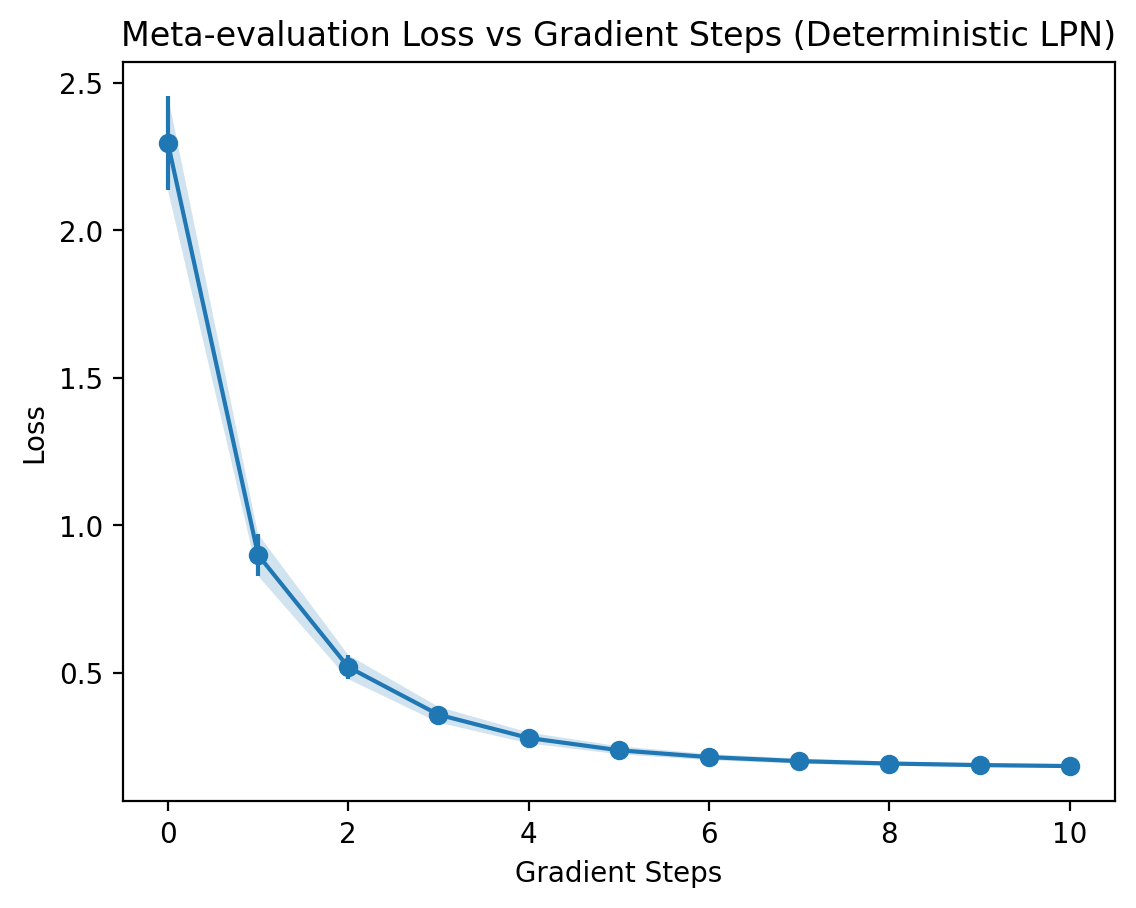

In [7]:
metaeval_losses, metaeval_mu, metaeval_ci = evaluate_deterministic_lpn(lpn, device)




In [ ]:
eval_df = pd.DataFrame({"mu": metaeval_mu, "ci": metaeval_ci})

eval_df.to_csv("..//eval_data/LPN_eval_tuned.csv")

(2000, 11)
(11,)



torch.sum(mse).item()=39.64336395263672
torch.sum(mse).item()=6.395421504974365
torch.sum(mse).item()=1.581430435180664
torch.sum(mse).item()=0.8150507807731628
torch.sum(mse).item()=0.6786486506462097
torch.sum(mse).item()=0.6537612676620483
torch.sum(mse).item()=0.6483234167098999
torch.sum(mse).item()=0.6473087668418884
torch.sum(mse).item()=0.6471143960952759
torch.sum(mse).item()=0.647076427936554
torch.sum(mse).item()=0.6470692157745361
torch.sum(mse).item()=0.6470656394958496
torch.sum(mse).item()=0.6469522714614868
torch.sum(mse).item()=0.6469389200210571
torch.sum(mse).item()=0.6469354033470154
torch.sum(mse).item()=0.6469357013702393
torch.sum(mse).item()=0.6469361186027527
torch.sum(mse).item()=0.6469354629516602
torch.sum(mse).item()=0.6469345092773438
torch.sum(mse).item()=0.6469345092773438
torch.sum(mse).item()=0.6469348073005676
torch.sum(mse).item()=0.6469342112541199
torch.sum(mse).item()=0.646934986114502
torch.sum(mse).item()=0.6469346880912781
torch.sum(mse).item()

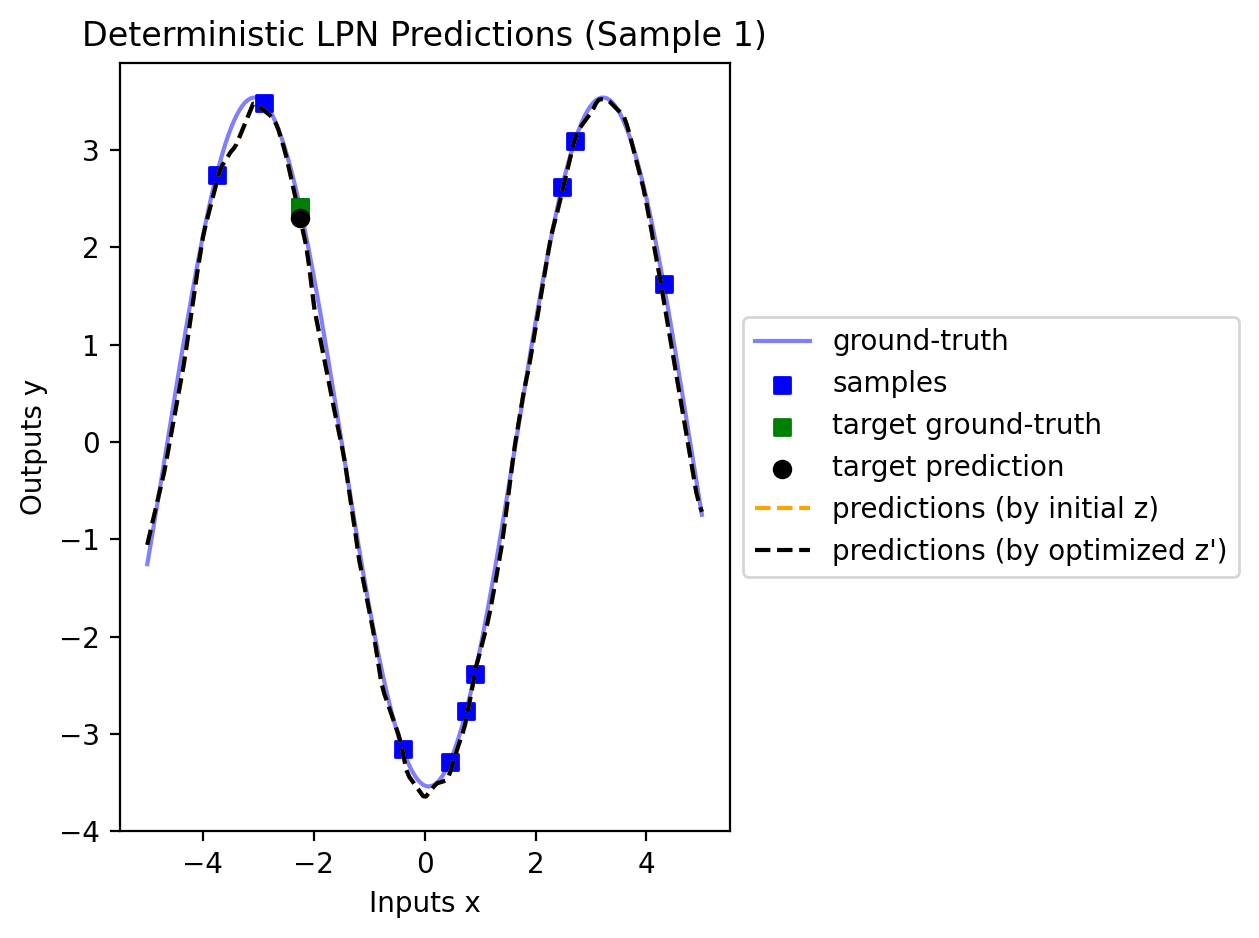

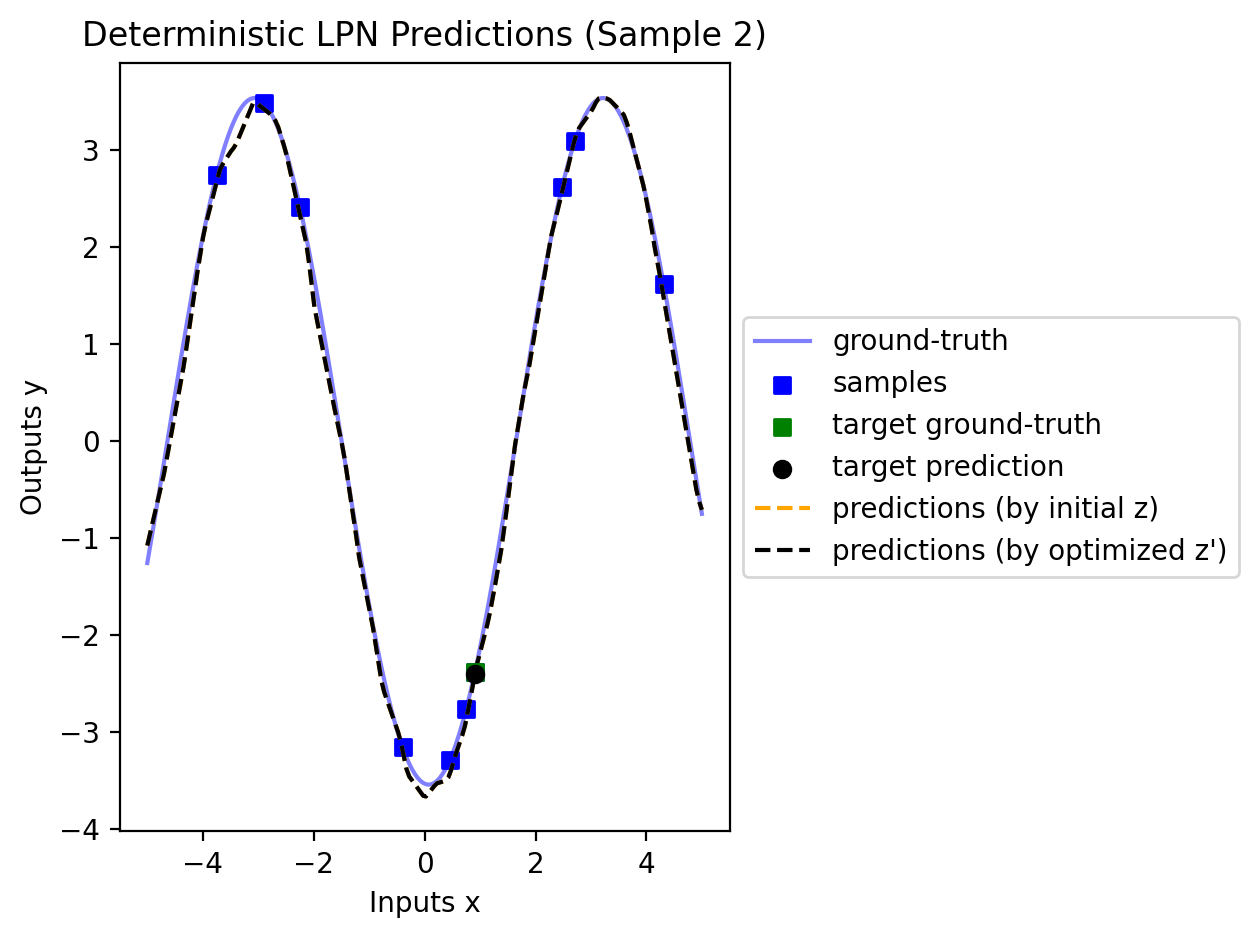

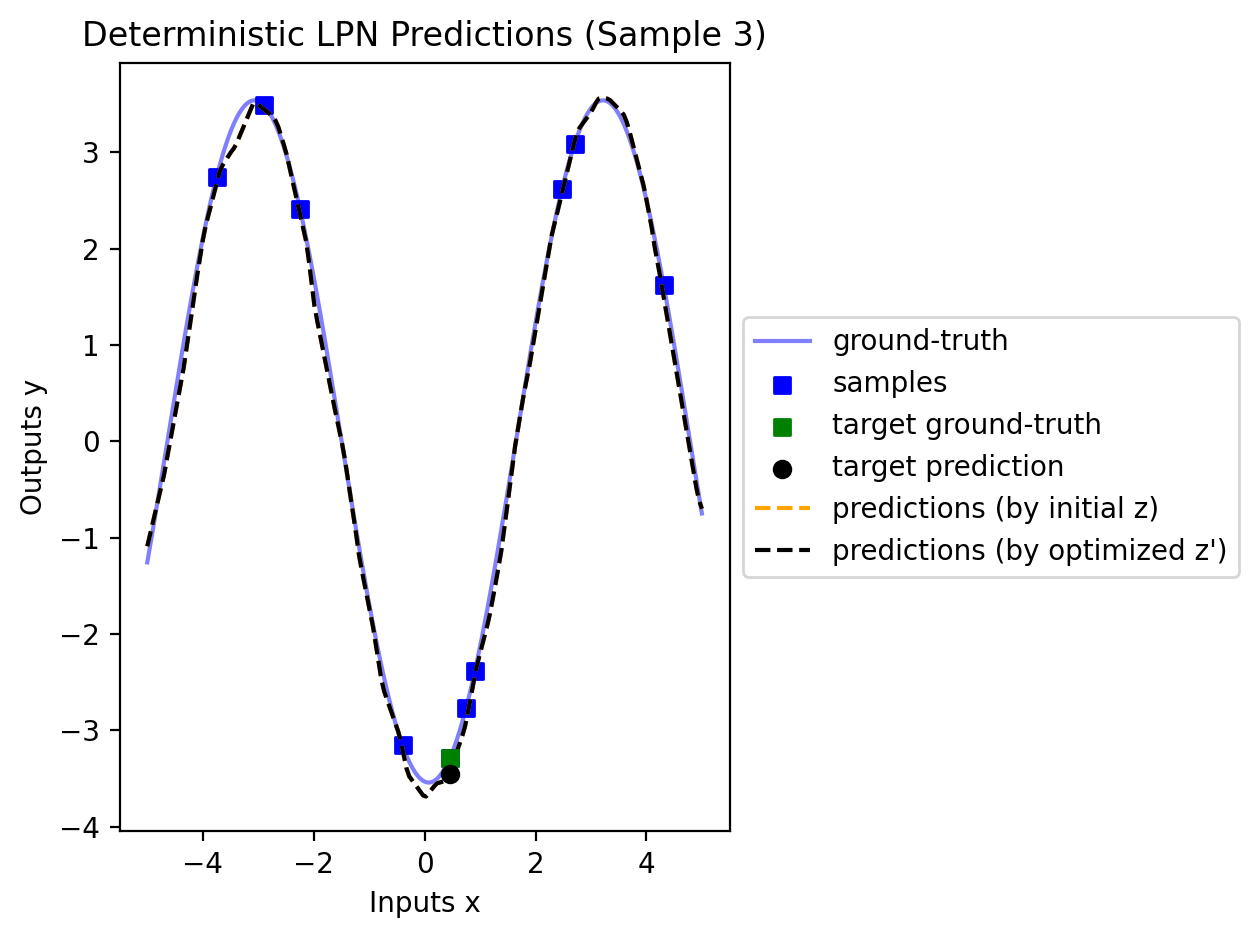

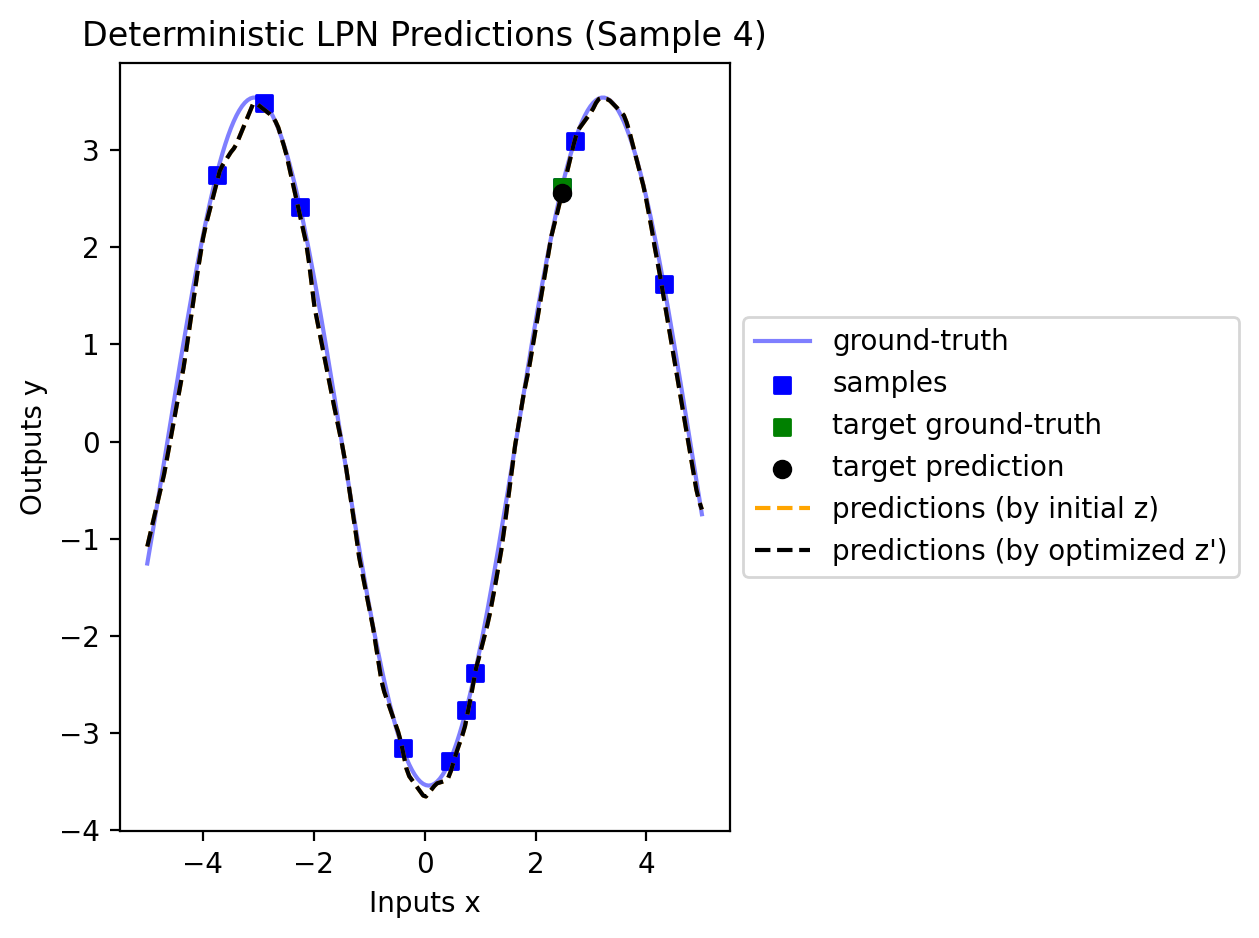

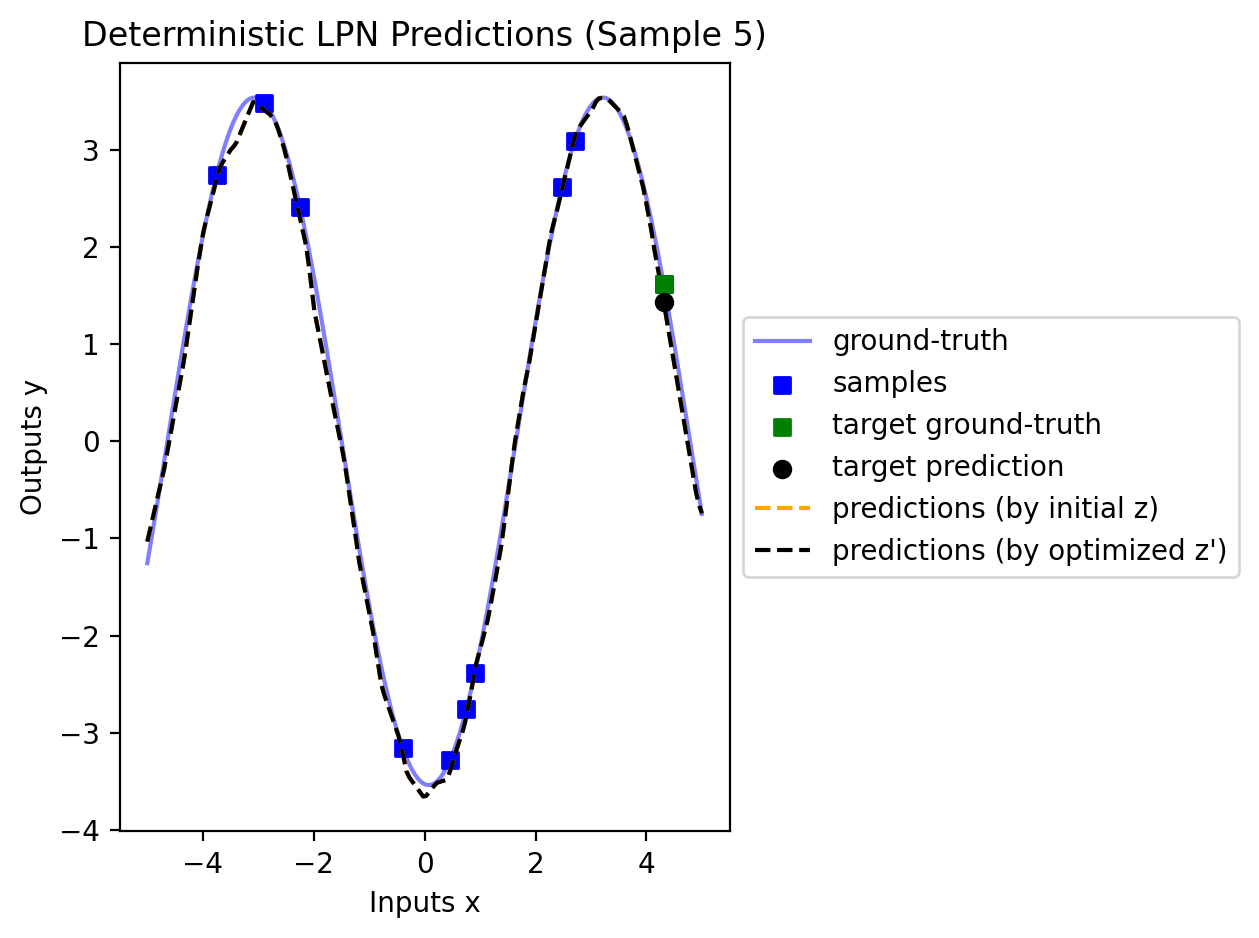

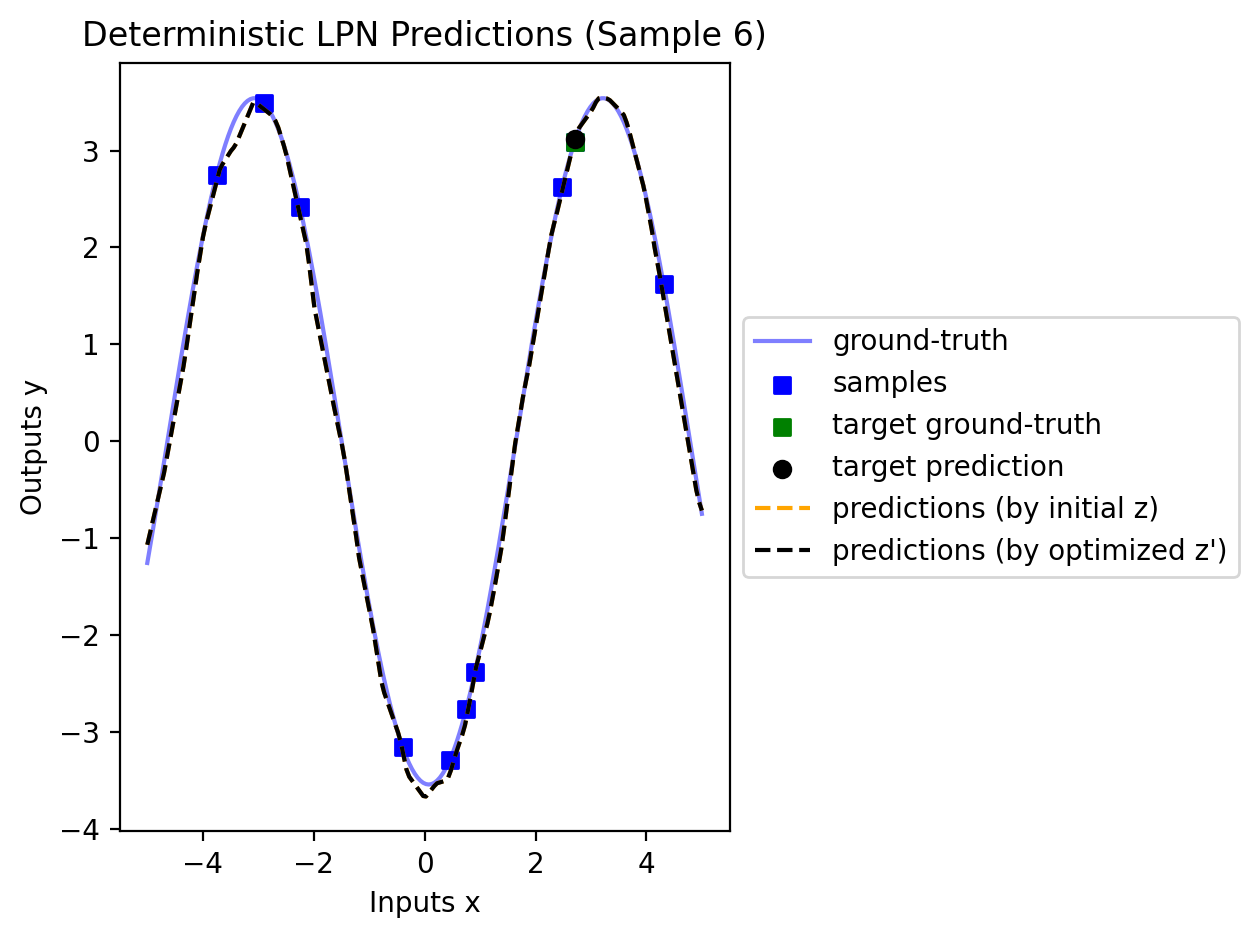

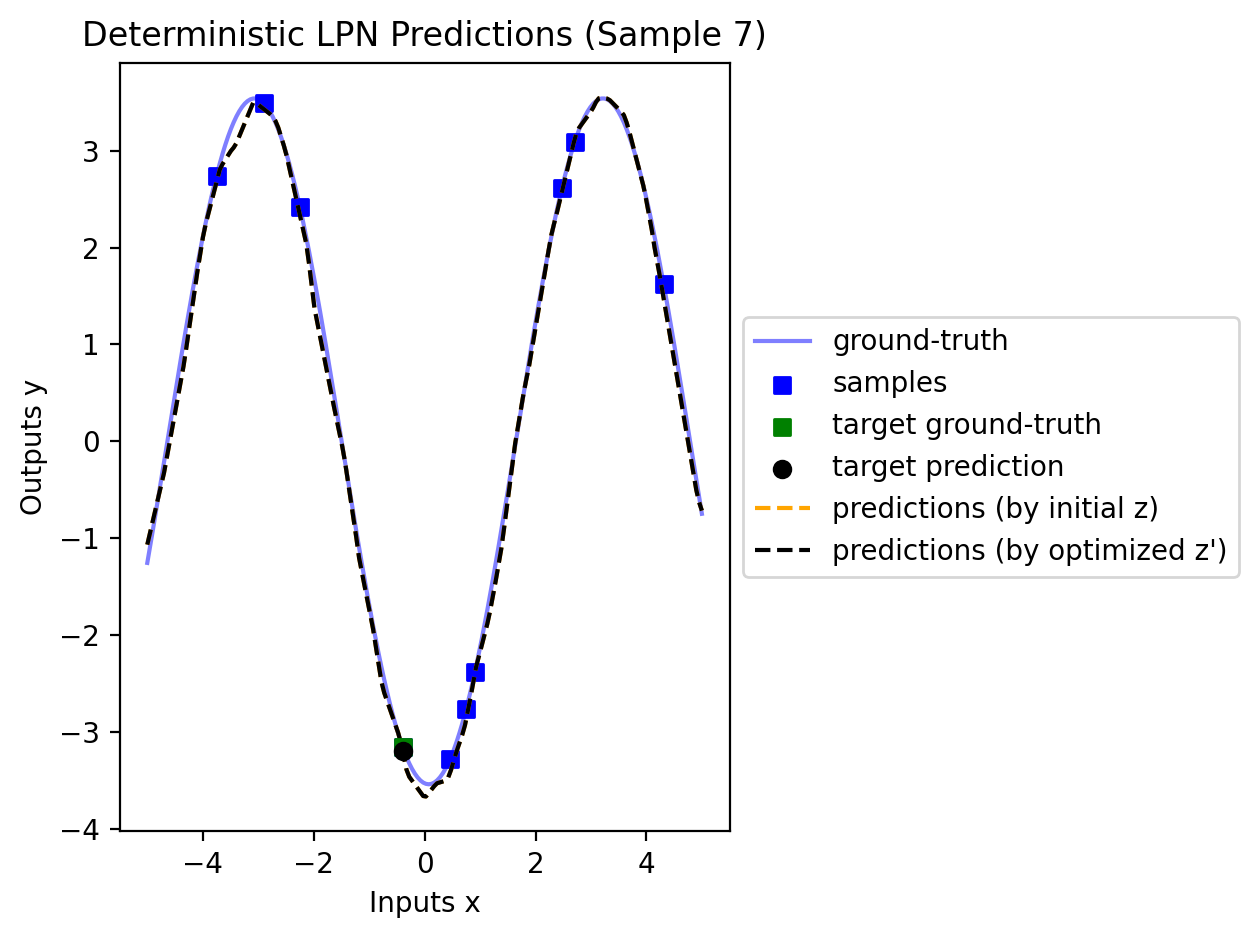

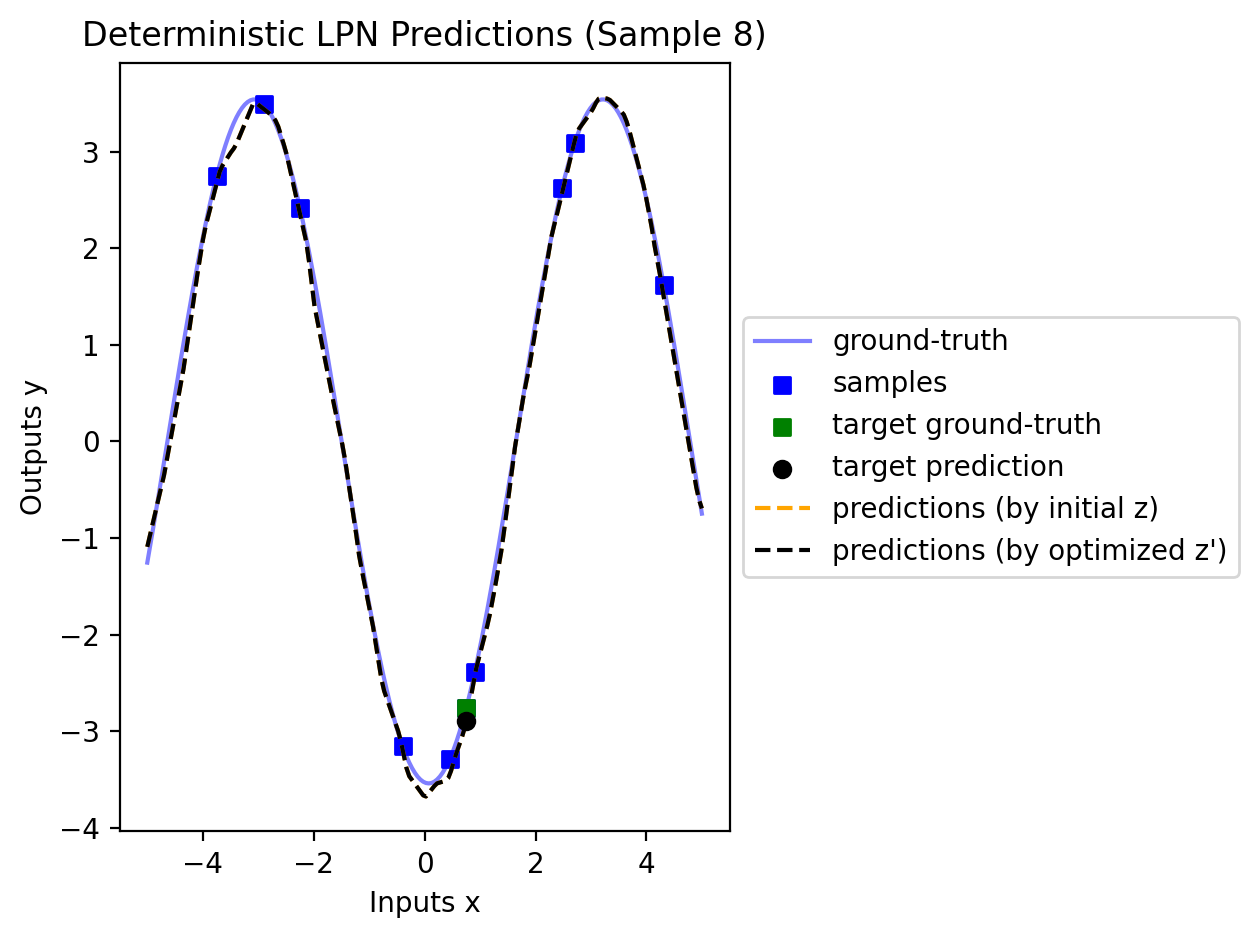

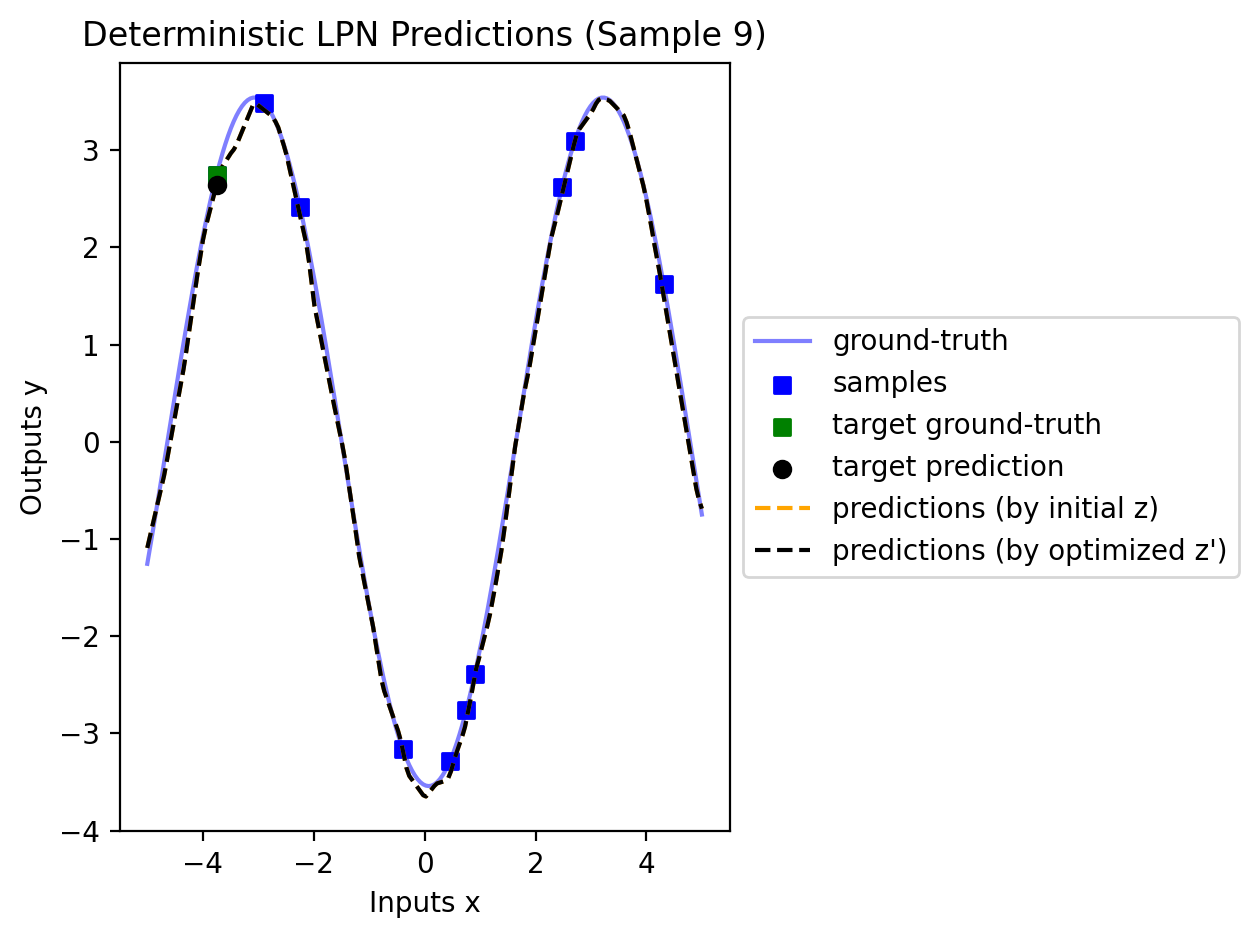

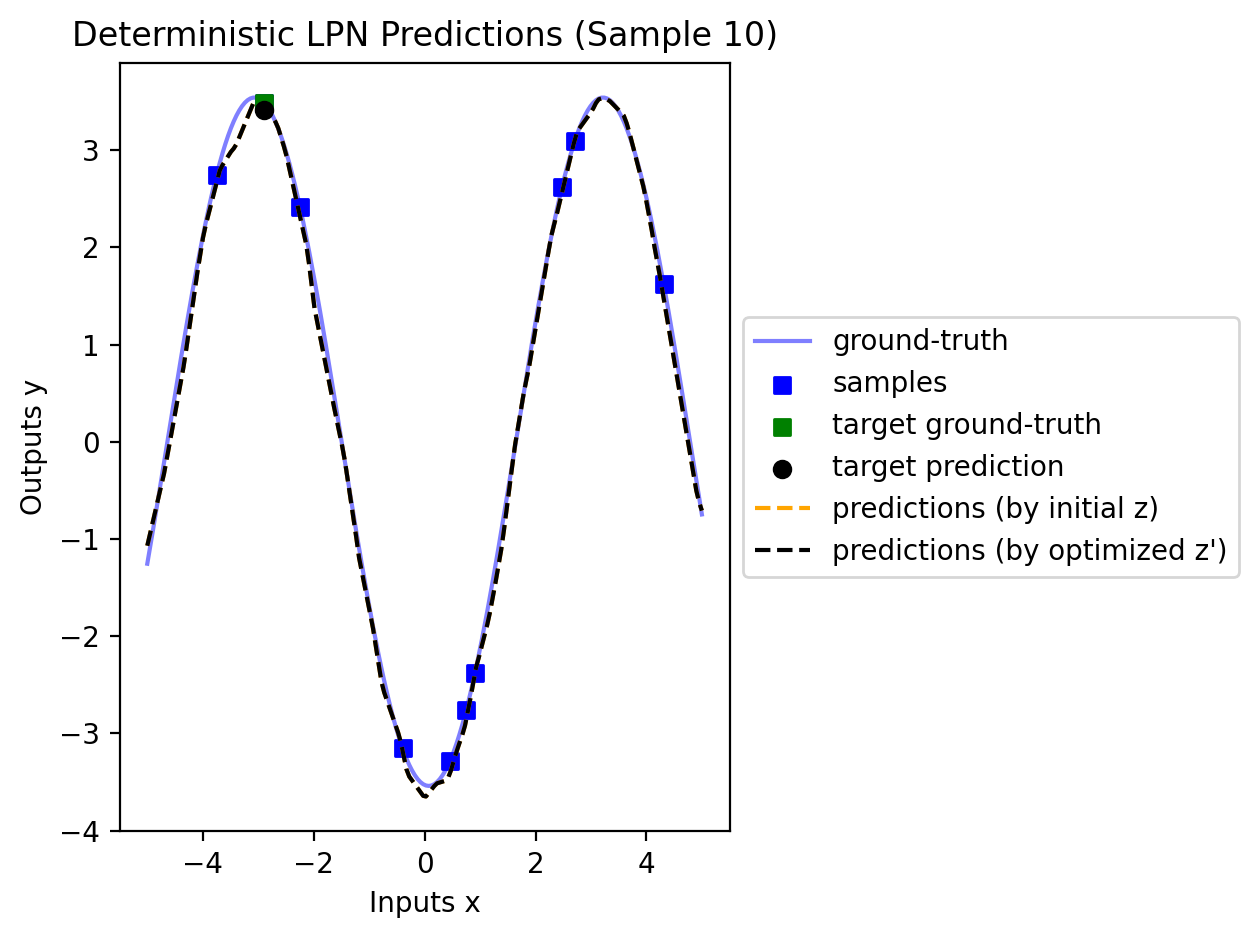

In [9]:
visualize_deterministic_lpn(lpn, device)